# 1. Imports

In [1]:
from impt_functions import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import pandas as pd 
import numpy as np
from fairlearn.reductions import ExponentiatedGradient, GridSearch, DemographicParity, EqualizedOdds, \
    TruePositiveRateParity, FalsePositiveRateParity, ErrorRateParity, BoundedGroupLoss
from fairlearn.metrics import *
from raiwidgets import FairnessDashboard
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
%matplotlib inline

# 2. Prepare data

In [2]:
data = get_data('/home/mackenzie/git_repositories/delayedimpact/data/simData_oom100.csv')

       score  repay_probability  race  repay_indices
0        601              75.21     1              1
1        693              95.15     1              1
2        791              98.62     1              1
3        637              86.69     1              1
4        775              98.45     1              1
...      ...                ...   ...            ...
99995    797              98.73     1              1
99996    562              58.57     1              1
99997    687              94.60     1              1
99998    589              70.61     1              1
99999    555              52.97     1              0

[100000 rows x 4 columns]


In [3]:
X_train, X_test, y_train, y_test, race_train, race_test, sample_weight_train, sample_weight_test = prep_data(data=data, test_size=0.3, weight_index=1)

Here are the x values:  [[601   1]
 [693   1]
 [791   1]
 ...
 [687   1]
 [589   1]
 [555   1]] 

Here are the y values:  [1 1 1 ... 1 1 0]
Sample weights are all equal.


# Decision Tree Classifier

## Train DTC classifier + Collect Predictions
NOTE: atm sample_weight are all 1s

In [4]:
# Reference: https://www.datacamp.com/community/tutorials/decision-tree-classification-python

# Initialize classifier:
clf = DecisionTreeClassifier()

# Train the classifier:
model = clf.fit(X_train,y_train)

# Make predictions with the classifier:
y_predict = model.predict(X_test)

# Scores on test set
test_scores = model.predict_proba(X_test)[:, 1]

### Evaluation of classifier overall

In [5]:
# Metrics
models_dict = {"Unmitigated": (y_predict, test_scores)}
get_metrics_df(models_dict, y_test, race_test)

,Unmitigated
Overall selection rate,0.729567
Demographic parity difference,0.450625
Demographic parity ratio,0.424364
------,
Overall balanced error rate,0.151732
Balanced error rate difference,0.0170221
------,
True positive rate difference,0.190934
True negative rate difference,0.156889
False positive rate difference,0.156889


In [6]:
cm = confusion_matrix(y_test, y_predict)
print(cm)
print(classification_report(y_test, y_predict)) 
evaluation_outcome_rates(y_test, y_predict, sample_weight_test)
get_f1_scores(y_test, y_predict)
get_selection_rates(y_test, y_predict, race_test, 0)

[[ 6644  2036]
 [ 1469 19851]]
              precision    recall  f1-score   support

           0       0.82      0.77      0.79      8680
           1       0.91      0.93      0.92     21320

    accuracy                           0.88     30000
   macro avg       0.86      0.85      0.86     30000
weighted avg       0.88      0.88      0.88     30000

TNR=TN/(TN+FP)=  0.7654377880184332
TPR=TP/(FP+FN)=  0.9310975609756098
FNER=FN/(FN+TP)=  0.06890243902439025
FPER=FP/(FP+TN)=  0.23456221198156682
F1 score micro: 
0.8831666666666667
F1 score weighted: 
0.8819608768731572
F1 score binary: 
0.9188788853657973
Selection Rate Overall:  0.7295666666666667


The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error


### Evaluation of classifier by race

In [7]:
evaluation_by_race(X_test, y_test, race_test, y_predict, sample_weight_test)

Selection Rate By Group:  sensitive_feature_0
0    0.332205
1    0.782831
Name: selection_rate, dtype: object 

EVALUATION FOR BLACK GROUP
[[2071  283]
 [ 297  895]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2354
           1       0.76      0.75      0.76      1192

    accuracy                           0.84      3546
   macro avg       0.82      0.82      0.82      3546
weighted avg       0.84      0.84      0.84      3546

TNR=TN/(TN+FP)=  0.8797790994052677
TPR=TP/(FP+FN)=  0.7508389261744967
FNER=FN/(FN+TP)=  0.24916107382550334
FPER=FP/(FP+TN)=  0.12022090059473237
F1 score micro: 
0.8364354201917654
F1 score weighted: 
0.8361947899037017
F1 score binary: 
0.7552742616033755

EVALUATION FOR WHITE GROUP
[[ 4573  1753]
 [ 1172 18956]]
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      6326
           1       0.92      0.94      0.93     20128

    accuracy            

### Delayed impact calculated by race

In [8]:
calculate_delayed_impact(X_test, y_test, y_predict, race_test)

The delayed impact of the black group is:  6.958544839255499
The delayed impact of the white group is:  43.80244953504196


### Fairness Metric Evaluation of classifier

In [9]:
print_fairness_metrics(y_test, y_predict, race_test)

DP Difference:  0.45062527207781544
-->difference of 0 means that all groups have the same selection rate
DP Ratio: 0.42436424030390024
-->ratio of 1 means that all groups have the same selection rate 

EOD Difference:  0.1909337288334525
-->difference of 0 means that all groups have the same TN, TN, FP, and FN rates
EOD Ratio: 0.4338376595335293
-->ratio of 1 means that all groups have the same TN, TN, FP, and FN rates rates 



## Exponentiated Gradient Reduction Alg for Adding Fairness Constraints

### Demographic Parity

In [ ]:
eg_dp = add_contraint(model, 'DP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

Exponentiated Gradient Reduction Alg is used here with  DP  as the fairness constraint.



### Equalized Odds

In [12]:
eg_eo = add_contraint(model, 'EO', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

Exponentiated Gradient Reduction Alg is used here with  EO  as the fairness constraint.

Evaluation of  EO -constrained classifier overall:
[[ 6561  2119]
 [ 2192 19128]]
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      8680
           1       0.90      0.90      0.90     21320

    accuracy                           0.86     30000
   macro avg       0.82      0.83      0.83     30000
weighted avg       0.86      0.86      0.86     30000

TNR=TN/(TN+FP)=  0.7558755760368664
TPR=TP/(FP+FN)=  0.8971857410881802
FNER=FN/(FN+TP)=  0.10281425891181989
FPER=FP/(FP+TN)=  0.24412442396313364
F1 score micro: 
0.8563
F1 score weighted: 
0.8564776503509381
F1 score binary: 
0.8987243639439002


Evaluation of  EO -constrained classifier by race:
EVALUATION FOR BLACK GROUP
[[1748  606]
 [ 144 1048]]
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      2354
           1       0.63      0.88     

The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error


DP Difference:  0.2742030766428255
-->difference of 0 means that all groups have the same selection rate
DP Ratio: 0.6297775639509362
-->ratio of 1 means that all groups have the same selection rate 

EOD Difference:  0.01905656149635626
-->difference of 0 means that all groups have the same TN, TN, FP, and FN rates
EOD Ratio: 0.9290595989728597
-->ratio of 1 means that all groups have the same TN, TN, FP, and FN rates rates 

The delayed impact of the black group is:  -3.4686971235194584
The delayed impact of the white group is:  42.6797459741438


### EOO (True Positive Rate Parity)

In [13]:
eg_tprp = add_contraint(model, 'TPRP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

Exponentiated Gradient Reduction Alg is used here with  TPRP  as the fairness constraint.

Evaluation of  TPRP -constrained classifier overall:
[[ 6216  2464]
 [ 1448 19872]]
              precision    recall  f1-score   support

           0       0.81      0.72      0.76      8680
           1       0.89      0.93      0.91     21320

    accuracy                           0.87     30000
   macro avg       0.85      0.82      0.84     30000
weighted avg       0.87      0.87      0.87     30000

TNR=TN/(TN+FP)=  0.7161290322580646
TPR=TP/(FP+FN)=  0.9320825515947467
FNER=FN/(FN+TP)=  0.06791744840525328
FPER=FP/(FP+TN)=  0.2838709677419355
F1 score micro: 
0.8695999999999999
F1 score weighted: 
0.8670643312809774
F1 score binary: 
0.9103903243540407


Evaluation of  TPRP -constrained classifier by race:
EVALUATION FOR BLACK GROUP
[[1496  858]
 [ 110 1082]]
              precision    recall  f1-score   support

           0       0.93      0.64      0.76      2354
           1       0.

The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error


Selection Rate Overall:  0.7445333333333334
Selection Rate By Group:  sensitive_feature_0
0    0.547095
1    0.770999
Name: selection_rate, dtype: object 

DP Difference:  0.22390339608120957
-->difference of 0 means that all groups have the same selection rate
DP Ratio: 0.7095930358927085
-->ratio of 1 means that all groups have the same selection rate 

EOD Difference:  0.11061307583892022
-->difference of 0 means that all groups have the same TN, TN, FP, and FN rates
EOD Ratio: 0.696523099621424
-->ratio of 1 means that all groups have the same TN, TN, FP, and FN rates rates 

The delayed impact of the black group is:  -13.40947546531303
The delayed impact of the white group is:  44.165343615332276


### False Positive Rate Parity

In [14]:
eg_fprp = add_contraint(model, 'FPRP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

Exponentiated Gradient Reduction Alg is used here with  FPRP  as the fairness constraint.

Evaluation of  FPRP -constrained classifier overall:
[[ 6393  2287]
 [ 1388 19932]]
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      8680
           1       0.90      0.93      0.92     21320

    accuracy                           0.88     30000
   macro avg       0.86      0.84      0.85     30000
weighted avg       0.88      0.88      0.88     30000

TNR=TN/(TN+FP)=  0.7365207373271889
TPR=TP/(FP+FN)=  0.9348968105065666
FNER=FN/(FN+TP)=  0.0651031894934334
FPER=FP/(FP+TN)=  0.2634792626728111
F1 score micro: 
0.8775
F1 score weighted: 
0.8754195958866932
F1 score binary: 
0.9155929166953766


Evaluation of  FPRP -constrained classifier by race:
EVALUATION FOR BLACK GROUP
[[1742  612]
 [ 146 1046]]
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      2354
           1       0.63      0.88 

The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error


Selection Rate Overall:  0.7406333333333334
Selection Rate By Group:  sensitive_feature_0
0    0.467569
1    0.777236
Name: selection_rate, dtype: object 

DP Difference:  0.30966686482054795
-->difference of 0 means that all groups have the same selection rate
DP Ratio: 0.6015793374853959
-->ratio of 1 means that all groups have the same selection rate 

EOD Difference:  0.06077813403612842
-->difference of 0 means that all groups have the same TN, TN, FP, and FN rates
EOD Ratio: 0.9352249135931805
-->ratio of 1 means that all groups have the same TN, TN, FP, and FN rates rates 

The delayed impact of the black group is:  -3.7648054145516077
The delayed impact of the white group is:  44.046268995237014


### Error Rate Parity

In [15]:
eg_erp = add_contraint(model, 'ERP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

Exponentiated Gradient Reduction Alg is used here with  ERP  as the fairness constraint.

Evaluation of  ERP -constrained classifier overall:
[[ 6499  2181]
 [ 2199 19121]]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      8680
           1       0.90      0.90      0.90     21320

    accuracy                           0.85     30000
   macro avg       0.82      0.82      0.82     30000
weighted avg       0.85      0.85      0.85     30000

TNR=TN/(TN+FP)=  0.7487327188940092
TPR=TP/(FP+FN)=  0.8968574108818012
FNER=FN/(FN+TP)=  0.10314258911819887
FPER=FP/(FP+TN)=  0.2512672811059908
F1 score micro: 
0.854
F1 score weighted: 
0.8540447836945598
F1 score binary: 
0.8972361691145418


Evaluation of  ERP -constrained classifier by race:
EVALUATION FOR BLACK GROUP
[[2071  283]
 [ 297  895]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2354
           1       0.76      0.75    

The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error


DP Difference:  0.4285114140601244
-->difference of 0 means that all groups have the same selection rate
DP Ratio: 0.43670041008017635
-->ratio of 1 means that all groups have the same selection rate 

EOD Difference:  0.1798107149601206
-->difference of 0 means that all groups have the same TN, TN, FP, and FN rates
EOD Ratio: 0.40069410809392886
-->ratio of 1 means that all groups have the same TN, TN, FP, and FN rates rates 

The delayed impact of the black group is:  6.958544839255499
The delayed impact of the white group is:  40.91063733272851


### Bounded Group Loss (TODO: issue, need to figure out loss parameter)

In [16]:
#add_contraint(model, 'BGL', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

## Grid Search Reduction Alg for Adding Fairness Constraints

### Demographic Parity

In [17]:
gs_dp = add_contraint(model, 'DP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

Grid Search Reduction Alg is used here with  DP  as the fairness constraint.

Evaluation of  DP -constrained classifier overall:
[[ 5907  2773]
 [ 1317 20003]]
              precision    recall  f1-score   support

           0       0.82      0.68      0.74      8680
           1       0.88      0.94      0.91     21320

    accuracy                           0.86     30000
   macro avg       0.85      0.81      0.83     30000
weighted avg       0.86      0.86      0.86     30000

TNR=TN/(TN+FP)=  0.6805299539170507
TPR=TP/(FP+FN)=  0.9382270168855534
FNER=FN/(FN+TP)=  0.06177298311444653
FPER=FP/(FP+TN)=  0.3194700460829493
F1 score micro: 
0.8636666666666667
F1 score weighted: 
0.8596768425015502
F1 score binary: 
0.9072478229317851


Evaluation of  DP -constrained classifier by race:
EVALUATION FOR BLACK GROUP
[[1256 1098]
 [  75 1117]]
              precision    recall  f1-score   support

           0       0.94      0.53      0.68      2354
           1       0.50      0.94     

The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error


Selection Rate Overall:  0.7592
Selection Rate By Group:  sensitive_feature_0
0    0.624647
1    0.777236
Name: selection_rate, dtype: object 

DP Difference:  0.1525884666253985
-->difference of 0 means that all groups have the same selection rate
DP Ratio: 0.8036780654584752
-->ratio of 1 means that all groups have the same selection rate 

EOD Difference:  0.20165983006034893
-->difference of 0 means that all groups have the same TN, TN, FP, and FN rates
EOD Ratio: 0.5676618943879223
-->ratio of 1 means that all groups have the same TN, TN, FP, and FN rates rates 

The delayed impact of the black group is:  -22.821489001692047
The delayed impact of the white group is:  44.046268995237014


In [18]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = gs_dp.lambda_vecs_
print(lambda_vecs[0])

sign  event  group_id
+     all    0           0.0
             1           0.0
-     all    0           0.0
             1           2.0
Name: 0, dtype: float64


The next few cells come from: https://github.com/fairlearn/fairlearn/blob/main/notebooks/Binary%20Classification%20with%20the%20UCI%20Credit-card%20Default%20Dataset.ipynb

Note: we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric.

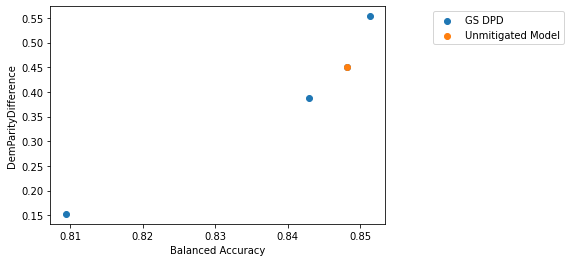

                               Unmitigated      GS DPD
Overall selection rate            0.729567      0.7592
Demographic parity difference     0.450625    0.152588
Demographic parity ratio          0.424364    0.803678
------                                                
Overall balanced error rate       0.151732    0.190622
Balanced error rate difference   0.0170221    0.101437
 ------                                               
True positive rate difference     0.190934  0.00121438
True negative rate difference     0.156889     0.20166
False positive rate difference    0.156889     0.20166
False negative rate difference    0.190934  0.00121438
Equalized odds difference         0.190934     0.20166
  ------                                              
Overall AUC                       0.933059    0.915544
AUC difference                   0.0352201   0.0352706


In [19]:
grid_search_show(gs_dp, demographic_parity_difference, y_predict, X_test, y_test, race_test, 'DemParityDifference','GS DPD', models_dict, 0.3)

In [20]:
models_dict.pop('GS DPD')
models_dict

{'Unmitigated': (array([1, 1, 1, ..., 1, 1, 1]),
  array([0.985     , 0.98409091, 1.        , ..., 0.88352273, 0.90196078,
         0.69662921]))}

### Equalized Odds Used

In [21]:
gs_eo = add_contraint(model, 'EO', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

Grid Search Reduction Alg is used here with  EO  as the fairness constraint.

Evaluation of  EO -constrained classifier overall:
[[ 6459  2221]
 [ 1402 19918]]
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      8680
           1       0.90      0.93      0.92     21320

    accuracy                           0.88     30000
   macro avg       0.86      0.84      0.85     30000
weighted avg       0.88      0.88      0.88     30000

TNR=TN/(TN+FP)=  0.7441244239631336
TPR=TP/(FP+FN)=  0.9342401500938087
FNER=FN/(FN+TP)=  0.06575984990619137
FPER=FP/(FP+TN)=  0.25587557603686634
F1 score micro: 
0.8792333333333333
F1 score weighted: 
0.8773814983521971
F1 score binary: 
0.9166340688925194


Evaluation of  EO -constrained classifier by race:
EVALUATION FOR BLACK GROUP
[[1808  546]
 [ 160 1032]]
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      2354
           1       0.65      0.87    

The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error


DP Difference:  0.3322274965182355
-->difference of 0 means that all groups have the same selection rate
DP Ratio: 0.5725525902002139
-->ratio of 1 means that all groups have the same selection rate 

EOD Difference:  0.0725231004790815
-->difference of 0 means that all groups have the same TN, TN, FP, and FN rates
EOD Ratio: 0.8759928479945218
-->ratio of 1 means that all groups have the same TN, TN, FP, and FN rates rates 

The delayed impact of the black group is:  -1.2690355329949239
The delayed impact of the white group is:  44.046268995237014


In [22]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = gs_eo.lambda_vecs_
print(lambda_vecs[0])

sign  event    group_id
+     label=0  0           0.0
               1           0.0
      label=1  0           0.0
               1           0.0
-     label=0  0           0.0
               1           2.0
      label=1  0           0.0
               1           0.0
Name: 0, dtype: float64


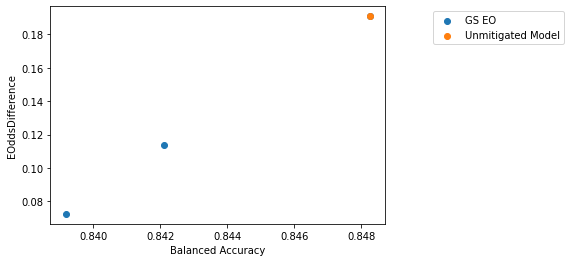

                               Unmitigated      GS EO
Overall selection rate            0.729567   0.737967
Demographic parity difference     0.450625   0.332227
Demographic parity ratio          0.424364   0.572553
------                                               
Overall balanced error rate       0.151732   0.160818
Balanced error rate difference   0.0170221  0.0198442
 ------                                              
True positive rate difference     0.190934  0.0725231
True negative rate difference     0.156889  0.0328346
False positive rate difference    0.156889  0.0328346
False negative rate difference    0.190934  0.0725231
Equalized odds difference         0.190934  0.0725231
  ------                                             
Overall AUC                       0.933059   0.926258
AUC difference                   0.0352201  0.0352513


In [23]:
grid_search_show(gs_eo, equalized_odds_difference, y_predict, X_test, y_test, race_test, 'EOddsDifference','GS EO', models_dict, 0.3)

In [24]:
models_dict.pop('GS EO')
models_dict

{'Unmitigated': (array([1, 1, 1, ..., 1, 1, 1]),
  array([0.985     , 0.98409091, 1.        , ..., 0.88352273, 0.90196078,
         0.69662921]))}

### EOO (True Positive Rate Parity)

In [25]:
gs_tprp = add_contraint(model, 'TPRP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

Grid Search Reduction Alg is used here with  TPRP  as the fairness constraint.

Evaluation of  TPRP -constrained classifier overall:
[[ 6411  2269]
 [ 1342 19978]]
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      8680
           1       0.90      0.94      0.92     21320

    accuracy                           0.88     30000
   macro avg       0.86      0.84      0.85     30000
weighted avg       0.88      0.88      0.88     30000

TNR=TN/(TN+FP)=  0.7385944700460829
TPR=TP/(FP+FN)=  0.9370544090056285
FNER=FN/(FN+TP)=  0.06294559099437148
FPER=FP/(FP+TN)=  0.261405529953917
F1 score micro: 
0.8796333333333334
F1 score weighted: 
0.8775188937426138
F1 score binary: 
0.9171161659053871


Evaluation of  TPRP -constrained classifier by race:
EVALUATION FOR BLACK GROUP
[[1838  516]
 [ 170 1022]]
              precision    recall  f1-score   support

           0       0.92      0.78      0.84      2354
           1       0.66      0.86

The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error


Selection Rate Overall:  0.7415666666666667
Selection Rate By Group:  sensitive_feature_0
0    0.433728
1    0.782831
Name: selection_rate, dtype: object 

DP Difference:  0.34910242943822156
-->difference of 0 means that all groups have the same selection rate
DP Ratio: 0.554051104912902
-->ratio of 1 means that all groups have the same selection rate 

EOD Difference:  0.08439010467237873
-->difference of 0 means that all groups have the same TN, TN, FP, and FN rates
EOD Ratio: 0.7910255558985906
-->ratio of 1 means that all groups have the same TN, TN, FP, and FN rates rates 

The delayed impact of the black group is:  -0.21150592216582065
The delayed impact of the white group is:  43.80244953504196


In [26]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = gs_tprp.lambda_vecs_
print(lambda_vecs[0])

sign  event    group_id
+     label=1  0           0.0
               1           0.0
-     label=1  0           0.0
               1           2.0
Name: 0, dtype: float64


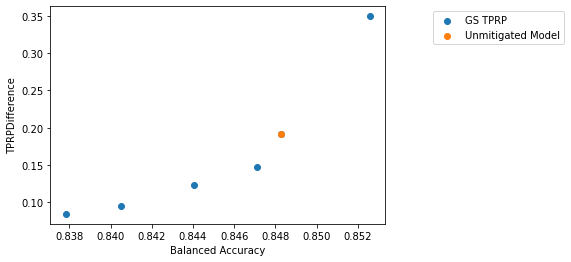

                               Unmitigated    GS TPRP
Overall selection rate            0.729567   0.741567
Demographic parity difference     0.450625   0.349102
Demographic parity ratio          0.424364   0.554051
------                                               
Overall balanced error rate       0.151732   0.162176
Balanced error rate difference   0.0170221  0.0132406
 ------                                              
True positive rate difference     0.190934  0.0843901
True negative rate difference     0.156889   0.057909
False positive rate difference    0.156889   0.057909
False negative rate difference    0.190934  0.0843901
Equalized odds difference         0.190934  0.0843901
  ------                                             
Overall AUC                       0.933059   0.927991
AUC difference                   0.0352201  0.0352615


In [27]:
grid_search_show(gs_tprp, true_positive_rate_difference, y_predict, X_test, y_test, race_test, 'TPRPDifference','GS TPRP', models_dict, 0.3)

In [28]:
models_dict.pop('GS TPRP')
models_dict

{'Unmitigated': (array([1, 1, 1, ..., 1, 1, 1]),
  array([0.985     , 0.98409091, 1.        , ..., 0.88352273, 0.90196078,
         0.69662921]))}

### False Positive Rate Parity

In [29]:
gs_fprp = add_contraint(model, 'FPRP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

Grid Search Reduction Alg is used here with  FPRP  as the fairness constraint.

Evaluation of  FPRP -constrained classifier overall:
[[ 6644  2036]
 [ 1469 19851]]
              precision    recall  f1-score   support

           0       0.82      0.77      0.79      8680
           1       0.91      0.93      0.92     21320

    accuracy                           0.88     30000
   macro avg       0.86      0.85      0.86     30000
weighted avg       0.88      0.88      0.88     30000

TNR=TN/(TN+FP)=  0.7654377880184332
TPR=TP/(FP+FN)=  0.9310975609756098
FNER=FN/(FN+TP)=  0.06890243902439025
FPER=FP/(FP+TN)=  0.23456221198156682
F1 score micro: 
0.8831666666666667
F1 score weighted: 
0.8819608768731572
F1 score binary: 
0.9188788853657973


Evaluation of  FPRP -constrained classifier by race:
EVALUATION FOR BLACK GROUP
[[2071  283]
 [ 297  895]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2354
           1       0.76      0.

The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error


Selection Rate Overall:  0.7295666666666667
Selection Rate By Group:  sensitive_feature_0
0    0.332205
1    0.782831
Name: selection_rate, dtype: object 

DP Difference:  0.45062527207781544
-->difference of 0 means that all groups have the same selection rate
DP Ratio: 0.42436424030390024
-->ratio of 1 means that all groups have the same selection rate 

EOD Difference:  0.1909337288334525
-->difference of 0 means that all groups have the same TN, TN, FP, and FN rates
EOD Ratio: 0.4338376595335293
-->ratio of 1 means that all groups have the same TN, TN, FP, and FN rates rates 

The delayed impact of the black group is:  6.958544839255499
The delayed impact of the white group is:  43.80244953504196


In [30]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = gs_fprp.lambda_vecs_
print(lambda_vecs[0])

sign  event    group_id
+     label=0  0           0.0
               1           0.0
-     label=0  0           0.0
               1           2.0
Name: 0, dtype: float64


In [31]:
# NOTE: the below models are the same!!

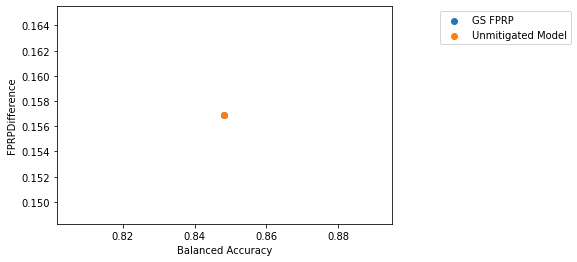

                               Unmitigated    GS FPRP
Overall selection rate            0.729567   0.729567
Demographic parity difference     0.450625   0.450625
Demographic parity ratio          0.424364   0.424364
------                                               
Overall balanced error rate       0.151732   0.151732
Balanced error rate difference   0.0170221  0.0170221
 ------                                              
True positive rate difference     0.190934   0.190934
True negative rate difference     0.156889   0.156889
False positive rate difference    0.156889   0.156889
False negative rate difference    0.190934   0.190934
Equalized odds difference         0.190934   0.190934
  ------                                             
Overall AUC                       0.933059   0.933059
AUC difference                   0.0352201  0.0352201


In [32]:
grid_search_show(gs_fprp, false_positive_rate_difference, y_predict, X_test, y_test, race_test, 'FPRPDifference','GS FPRP', models_dict, 0.4)

In [33]:
models_dict.pop('GS FPRP')
models_dict

{'Unmitigated': (array([1, 1, 1, ..., 1, 1, 1]),
  array([0.985     , 0.98409091, 1.        , ..., 0.88352273, 0.90196078,
         0.69662921]))}

### Error Rate Parity

In [34]:
gs_erp = add_contraint(model, 'ERP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

Grid Search Reduction Alg is used here with  ERP  as the fairness constraint.

Evaluation of  ERP -constrained classifier overall:
[[ 6644  2036]
 [ 1469 19851]]
              precision    recall  f1-score   support

           0       0.82      0.77      0.79      8680
           1       0.91      0.93      0.92     21320

    accuracy                           0.88     30000
   macro avg       0.86      0.85      0.86     30000
weighted avg       0.88      0.88      0.88     30000

TNR=TN/(TN+FP)=  0.7654377880184332
TPR=TP/(FP+FN)=  0.9310975609756098
FNER=FN/(FN+TP)=  0.06890243902439025
FPER=FP/(FP+TN)=  0.23456221198156682
F1 score micro: 
0.8831666666666667
F1 score weighted: 
0.8819608768731572
F1 score binary: 
0.9188788853657973


Evaluation of  ERP -constrained classifier by race:
EVALUATION FOR BLACK GROUP
[[2071  283]
 [ 297  895]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2354
           1       0.76      0.75 

The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error


DP Difference:  0.45062527207781544
-->difference of 0 means that all groups have the same selection rate
DP Ratio: 0.42436424030390024
-->ratio of 1 means that all groups have the same selection rate 

EOD Difference:  0.1909337288334525
-->difference of 0 means that all groups have the same TN, TN, FP, and FN rates
EOD Ratio: 0.4338376595335293
-->ratio of 1 means that all groups have the same TN, TN, FP, and FN rates rates 

The delayed impact of the black group is:  6.958544839255499
The delayed impact of the white group is:  43.80244953504196


In [35]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = gs_erp.lambda_vecs_
print(lambda_vecs[0])

sign  event  group_id
+     all    0           0.0
             1           0.0
-     all    0           0.0
             1           2.0
Name: 0, dtype: float64


In [36]:
# Fairlearn doesnt have an erp difference metric for the below
#grid_search_show(gs_erp, error_difference, y_predict, X_test, y_test, race_test, 'ERDifference','GS ERP', models_dict, 0.3)
#models_dict.pop('GS FPRP')
#models_dict

### Bounded Group Loss (issue, need to figure out loss parameter)

In [37]:
#gs_bgl = add_contraint(model, 'BGL', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)

In [38]:
# We can examine the values of lambda_i chosen for us:
#lambda_vecs = gs_dp.lambda_vecs_
#print(lambda_vecs[0])